In [16]:
%matplotlib inline
import tensorflow as tf
import numpy as np

import vgg16
from loss import content_loss, style_loss, denoise_loss

from images import load_image, plot_images

In [3]:
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    
    model = vgg16.VGG16()
    session = tf.InteractiveSession(graph=model.graph)
    
    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()
    
    # Create the loss-function for the content-layers and -image.
    loss_content = content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = denoise_loss(model)
    
    #adjust levels of loss functions, normalize them
    #multiply them with a variable
    #taking reciprocal values of loss values of content, style, denoising
    #small constant to avoid divide by 0
    #adjustment value normalizes loss so approximately 1
    #weights should be set relative to each other dont depend on layers
    #we are using
    
    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')
     
    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])
    
    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))
    
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise
            
    gradient = tf.gradients(loss_combined, model.input)
    
    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, update_adj_denoise]
    
    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    #where we first init it
    mixed_image = np.random.rand(*content_image.shape) + 128
    
    
    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        #Remove single-dimensional entries from the shape of an array.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        #Ratio of weights:updates
        #akin to learning rate
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        #gradient descent
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        #Given an interval, values outside the interval are clipped 
        #to the interval edges.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [10]:
content_filename = 'data/content/dolphins.jpg'
content_image = load_image(content_filename, max_size=None)
style_filename = 'data/styles/random-art.jpg'
style_image = load_image(style_filename, max_size=300)

content_layer_ids = [4]
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

/home/vonum/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 1.32e-10, Style: 2.35e-29, Denoise: 2.20e-06


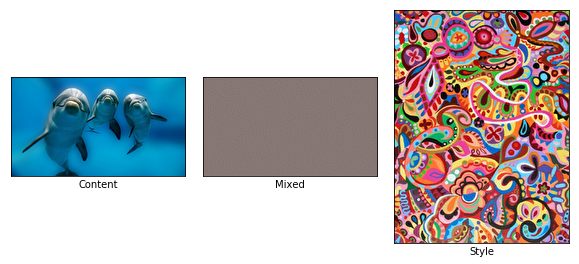

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 3.67e-11, Style: 1.66e-28, Denoise: 5.94e-08


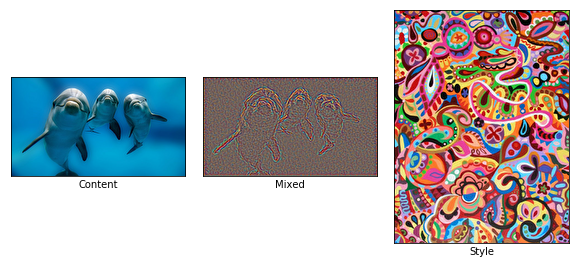

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 3.97e-11, Style: 4.47e-28, Denoise: 5.92e-08


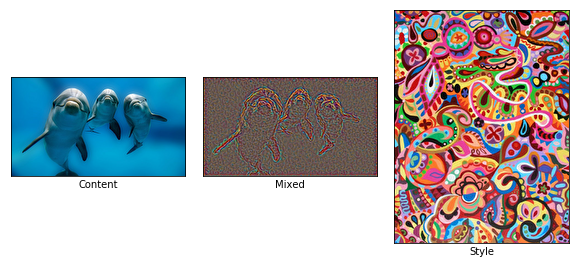

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 4.18e-11, Style: 9.55e-28, Denoise: 5.86e-08


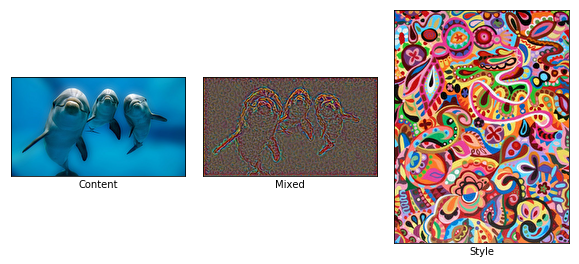

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 3.91e-11, Style: 6.41e-28, Denoise: 5.50e-08


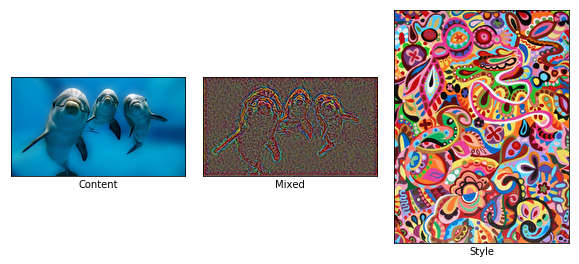

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 3.86e-11, Style: 6.58e-28, Denoise: 5.26e-08


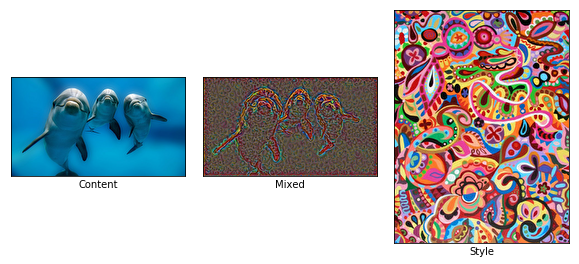

. . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 3.87e-11, Style: 7.31e-28, Denoise: 5.13e-08


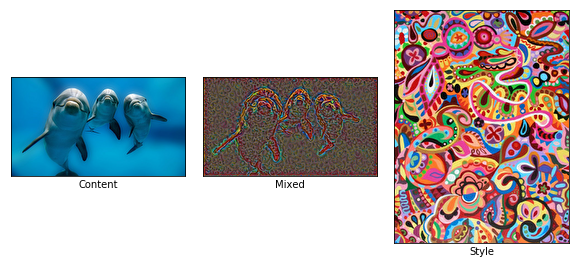

. . . . . . . . . . 
Iteration: 70
Weight Adj. for Content: 3.89e-11, Style: 7.68e-28, Denoise: 5.01e-08


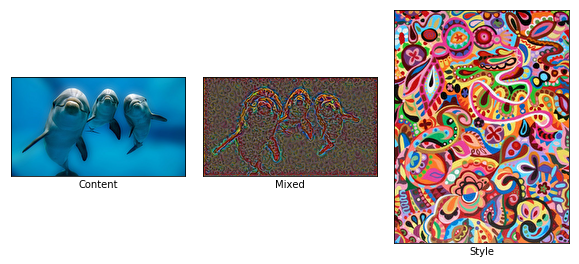

. . . . . . . . . . 
Iteration: 80
Weight Adj. for Content: 3.88e-11, Style: 7.76e-28, Denoise: 4.90e-08


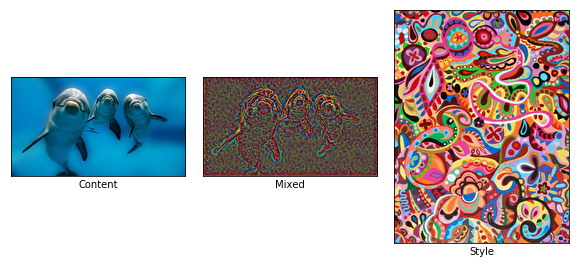

. . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 3.87e-11, Style: 7.59e-28, Denoise: 4.80e-08


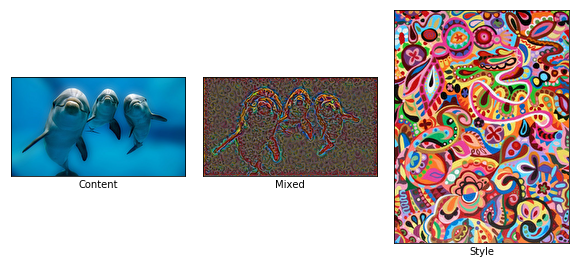

. . . . . . . . . . 
Iteration: 100
Weight Adj. for Content: 3.85e-11, Style: 7.30e-28, Denoise: 4.70e-08


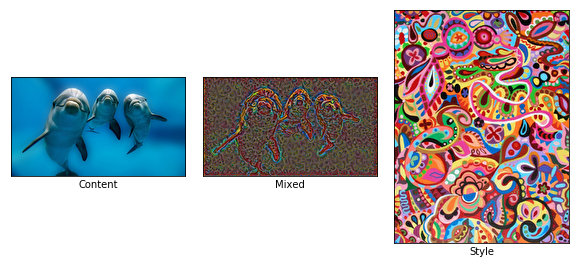

. . . . . . . . . . 
Iteration: 110
Weight Adj. for Content: 3.83e-11, Style: 6.96e-28, Denoise: 4.61e-08


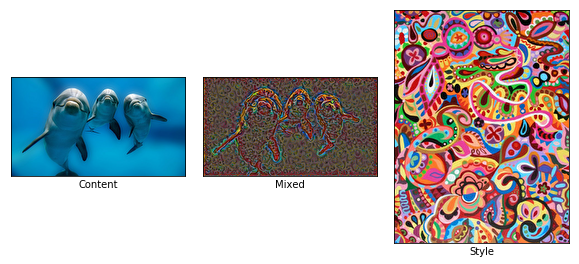

. . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 3.80e-11, Style: 6.64e-28, Denoise: 4.52e-08


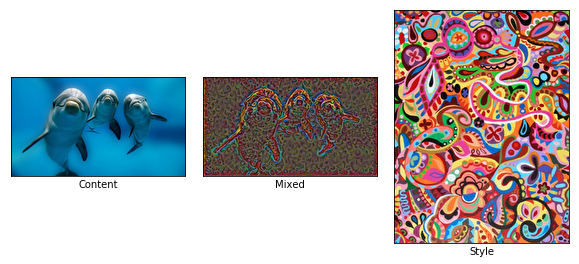

. . . . . . . . . . 
Iteration: 130
Weight Adj. for Content: 3.78e-11, Style: 6.38e-28, Denoise: 4.44e-08


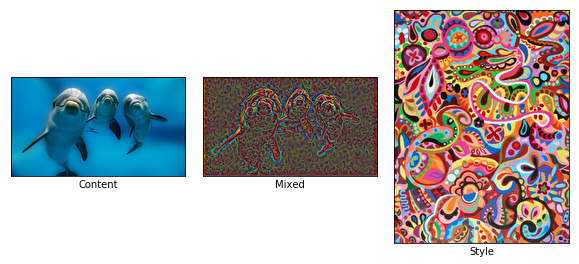

. . . . . . . . . . 
Iteration: 140
Weight Adj. for Content: 3.76e-11, Style: 6.10e-28, Denoise: 4.36e-08


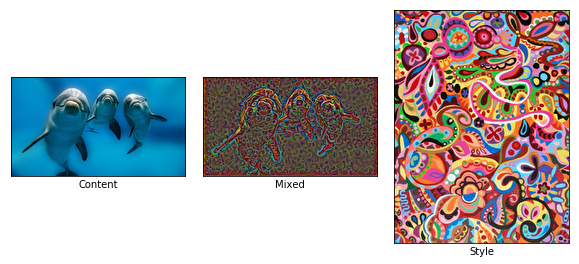

. . . . . . . . . . 
Iteration: 150
Weight Adj. for Content: 3.74e-11, Style: 5.88e-28, Denoise: 4.28e-08


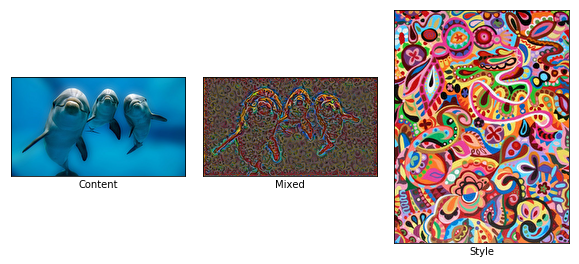

. . . . . . . . . . 
Iteration: 160
Weight Adj. for Content: 3.73e-11, Style: 5.69e-28, Denoise: 4.21e-08


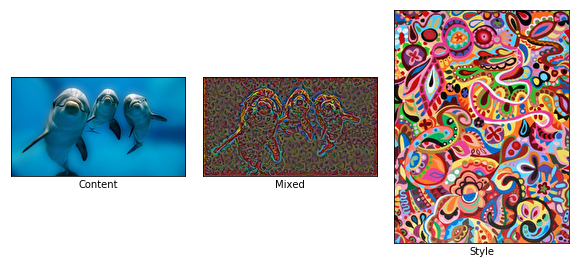

. . . . . . . . . . 
Iteration: 170
Weight Adj. for Content: 3.70e-11, Style: 5.53e-28, Denoise: 4.15e-08


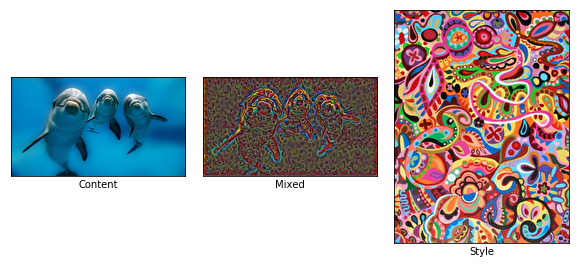

. . . . . . . . . . 
Iteration: 180
Weight Adj. for Content: 3.69e-11, Style: 5.36e-28, Denoise: 4.09e-08


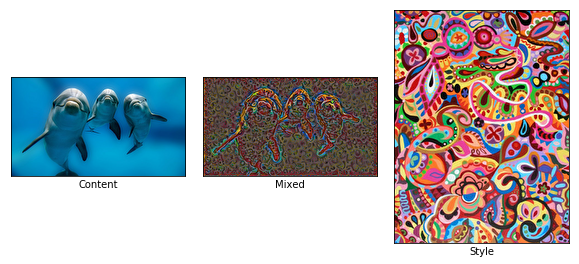

. . . . . . . . . . 
Iteration: 190
Weight Adj. for Content: 3.68e-11, Style: 5.25e-28, Denoise: 4.03e-08


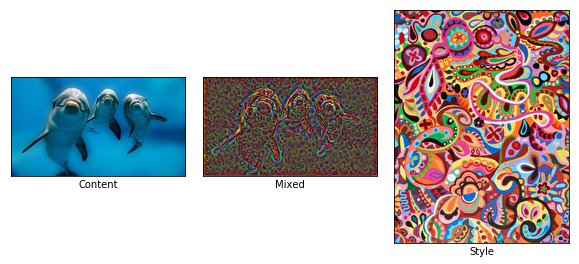

. . . . . . . . . 
Iteration: 199
Weight Adj. for Content: 5.90e-11, Style: 3.20e-28, Denoise: 4.77e-08


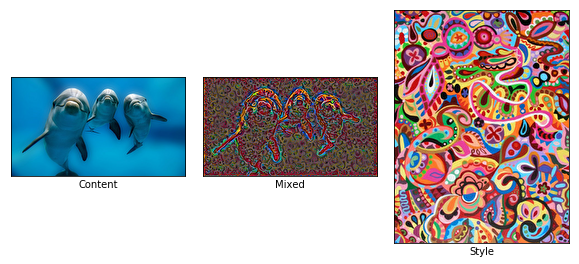


Final image:


NameError: name 'plot_image_big' is not defined

In [18]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=200,
                     step_size=10.0)